# CATE meta-model selection
The purpose of this notebook is to discern which statistical/ML model(s) we should use in our CATE estimators.

### CATE Estimators
 - Double machine learning CATE estimators predict $Y$ from $X,W \rightarrow$ `model_y`, as well as predict $T$ from $X,W \rightarrow$ `model_t` to estiamte the CATE

 - Doubly robust methods are similar to double machine learning, however the treatment variable $T$ is included as a feature in `model_y`. There is also a `model_final` which amalgamates these results.

In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import sys
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random_state = 100 # Ensure reproducible results

# DoWhy
import pygraphviz
from IPython.display import Image, display
import dowhy
from dowhy import CausalModel
import econml

# Generic ML imports
from scipy.stats import uniform, truncnorm, randint
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import meta_model_helpers as mmh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_final.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [3]:
# MIN DAG features
min_features = ['age', 'thickness_sum', 'antiplatelet', 'drain', 'recurrence']

In [4]:
# Categorical type conversion
categorical_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'optype', 'recurrence',
                        'drain', 'hospital', 'bedrest', 'warfarin', 'density', 'membranes', 'burrhole_num',
                        'bedrest']

for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes

In [5]:
# Define reduced datasets
csdh_min = csdh[min_features]

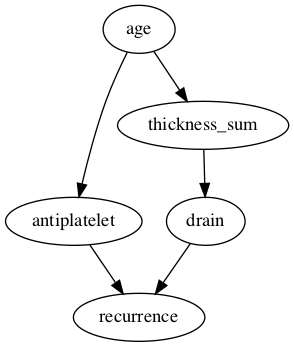

In [6]:
min_model = CausalModel(data=csdh_min, 
                        treatment='drain', 
                        outcome='recurrence', 
                        graph='../causal_graphs/min_dag.dot'.replace("\n", " "))
min_model.view_model()
display(Image(filename="causal_model.png"))

---
## Define set of classifiers to investigate

In [7]:
names = ['Dummy', 'LR', 'Linear SVM', 'RBF SVM', 'GB', 'RF', 'XGB']

In [8]:
# Naive Bayes exluded due to mixture of variable types
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    LogisticRegression(max_iter=1000),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    XGBClassifier(random_state=random_state),
]

# _Double Machine Learning:_ finding `model_y` and `model_t`.
- `model_y` models $\mathbb{E}[Y \mid X,W]$ where the treatment variable $T$ is omitted from the covariates
- `model_t` is the propensity model and involves estimating $P[T=1\mid X,W]$

## Predicting $Y$ (recurrence) from controls $X, W$; `model_y`

In [9]:
y_rec_full = csdh_min['recurrence']
X_rec_full = csdh_min.drop(['drain', 'recurrence'], axis=1)

In [10]:
# Split into validation set and rest
X_rec_rest, X_rec_val, y_rec_rest, y_rec_val = train_test_split(X_rec_full, y_rec_full, 
                                                                test_size=0.15,
                                                                random_state=random_state,
                                                                stratify=y_rec_full)

# Split rest into train and test set
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec_rest, y_rec_rest, 
                                                                    test_size=0.15,
                                                                    random_state=random_state,
                                                                    stratify=y_rec_rest)

In [11]:
rec_training_scores, rec_val_scores = mmh.train_and_validate_classifiers(X_rec_train, 
                                                                         y_rec_train,
                                                                         X_rec_val,
                                                                         y_rec_val,
                                                                         names,
                                                                         classifiers)

[15:21:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
mmh.print_metrics_table(rec_training_scores, rec_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.911    0.500    0.000    0.000   3.084    0.907    0.500    0.000    0.000    3.210
LR            0.911    0.500    0.000    0.000   3.084    0.907    0.500    0.000    0.000    3.210
Linear SVM    0.911    0.500    0.000    0.000   3.084    0.907    0.500    0.000    0.000    3.210
RBF SVM       0.911    0.500    0.000    0.000   3.084    0.907    0.500    0.000    0.000    3.210
GB            0.911    0.500    0.000    0.000   3.084    0.928    0.610    0.220    0.361    2.504
RF            0.893    0.490    0.000    0.000   3.701    0.974    0.860    0.720    0.837    0.899
XGB           0.893    0.490    0.000    0.000 

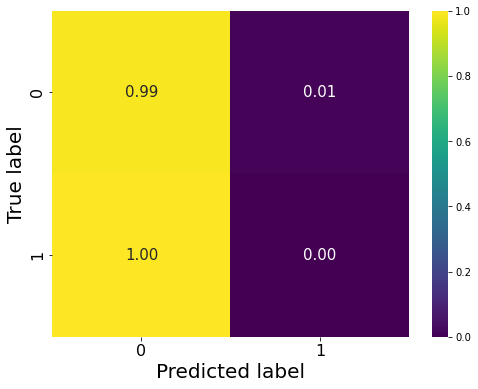

In [13]:
cm_rec_test = confusion_matrix(y_rec_test, classifiers[4].predict(X_rec_test), normalize='true')
mmh.plot_confusion_matrix(cm_rec_test, [0, 1])

## `model_y` K-Fold cross validation for hyperparameter tuning and model selection

In [14]:
# define cross-validation structure
cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [15]:
# define classifiers and hyperparameters to search over
rf = RandomForestClassifier()
params_rf = {
    # randomly sample numbers from 10 to 200 estimators
    'rf__n_estimators':randint(10, 200),
    
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'rf__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'rf__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators.
    
    'rf__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'rf__max_features':['sqrt', 'log2', None],
    # random seed
    'rf__random_state':[random_state],
    # Whether bootstrap samples are used when building trees
    'rf__bootstrap':[True, False]
}

gb = GradientBoostingClassifier()
params_gb = {
    # randomly sample numbers from 10 to 200 estimators
    'gb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'gb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'gb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1.0],
        
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'gb__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'gb__max_features':['sqrt', 'log2', None],
    # random seed
    'gb__random_state':[random_state]
}

xgb = XGBClassifier()
params_xgb = {
    # randomly sample numbers from 10 to 200 estimators
    'xgb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'xgb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'xgb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1],
    # min_split_loss
    'xgb__gamma':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3],
 
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'xgb__max_depth':randint(2, 15),
    # analagous to max_features in rf and gb
    'xgb__colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1],
    # random seed
    'xgb__random_state':[random_state],
}

In [16]:
# define search spaces for random search tuning
search_space = [('rf', rf, params_rf), ('gb', gb, params_gb), ('xgb', xgb, params_xgb)]

In [ ]:
# do the search
_,_, best_estimator_rec = mmh.randomized_search_cv(X_rec_rest, y_rec_rest, 
                                                   search_space, 
                                                   cv=cv_10,
                                                   refit=True,
                                                   n_iter=5000, 
                                                   verbose=True)

cv strategy StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'xgb__n_estimators': 17, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=17,
                               n_jobs=None, num_parallel_tree

cv score: [0.49712644 0.4454023  0.45258621 0.56206897 0.66520468 0.47222222
 0.29678363 0.54093567 0.34064327 0.2748538 ]
----------------------------------------
Trial 9
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
           

cv score: [0.52586207 0.46551724 0.57471264 0.50862069 0.6871345  0.4619883
 0.50292398 0.66081871 0.55409357 0.52339181]
----------------------------------------
Trial 17
----------------------------------------
Parameters {'gb__n_estimators': 155, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='log2',
                                            n_estimators=155, random_state=100,
                                            subsample=0.6))])
cv score: [0.54885057 0.45977011 0.60775862 0.72413793 0.62719298 0.62865497
 0.3377193  0.50292398 0.47076023 0.3625731 ]
----------------------------------------
Trial 18
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__ga

cv score: [0.39655172 0.44827586 0.56752874 0.53103448 0.48391813 0.61988304
 0.36988304 0.54678363 0.45614035 0.33333333]
----------------------------------------
Trial 26
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=142, random_state=100,
                                            subsample=0.8))])
cv score: [0.48994253 0.43965517 0.68103448 0.37413793 0.25438596 0.55701754
 0.29239766 0.50438596 0.62573099 0.60526316]
----------------------------------------
Trial 27
----------------------------------------
Parameters {'xgb__n_estimators': 29, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma

cv score: [0.40804598 0.43678161 0.45258621 0.56724138 0.73830409 0.52046784
 0.30263158 0.43567251 0.49415205 0.4005848 ]
----------------------------------------
Trial 36
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=31, random_state=100))])
cv score: [0.40229885 0.48563218 0.45258621 0.59655172 0.70321637 0.47660819
 0.26754386 0.54385965 0.47368421 0.28070175]
----------------------------------------
Trial 37
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_scor

cv score: [0.29885057 0.46551724 0.4841954  0.56034483 0.60087719 0.56140351
 0.50730994 0.54678363 0.47368421 0.43567251]
----------------------------------------
Trial 46
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            n_estimators=52, random_state=100,
                                            subsample=0.8))])
cv score: [0.50574713 0.50574713 0.43247126 0.50689655 0.73830409 0.45614035
 0.2880117  0.45321637 0.49415205 0.35964912]
----------------------------------------
Trial 47
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf'

cv score: [0.49712644 0.41091954 0.61637931 0.67931034 0.73245614 0.5994152
 0.31578947 0.4619883  0.49122807 0.33625731]
----------------------------------------
Trial 59
----------------------------------------
Parameters {'rf__n_estimators': 109, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=109,
                                        random_state=100))])
cv score: [0.54166667 0.46551724 0.56178161 0.67758621 0.63011696 0.59649123
 0.34795322 0.48245614 0.50292398 0.3245614 ]
----------------------------------------
Trial 60
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
     

cv score: [0.38505747 0.33333333 0.54741379 0.56551724 0.37719298 0.66081871
 0.53654971 0.58479532 0.31578947 0.26900585]
----------------------------------------
Trial 71
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=114, random_state=100))])
cv score: [0.48850575 0.40229885 0.44971264 0.58965517 0.73245614 0.48245614
 0.32602339 0.49707602 0.46783626 0.28070175]
----------------------------------------
Trial 72
----------------------------------------
Parameters {'gb__n_estimators': 119, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,

cv score: [0.37068966 0.32758621 0.65948276 0.63448276 0.54532164 0.6754386
 0.51315789 0.43274854 0.40350877 0.3245614 ]
----------------------------------------
Trial 82
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=165,
        

cv score: [0.48850575 0.45402299 0.4454023  0.57068966 0.59356725 0.57017544
 0.45760234 0.57602339 0.49415205 0.44736842]
----------------------------------------
Trial 93
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=93,
    

cv score: [0.54597701 0.4683908  0.47270115 0.56551724 0.65643275 0.51169591
 0.2880117  0.51754386 0.42105263 0.33625731]
----------------------------------------
Trial 104
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=193,
 

cv score: [0.38218391 0.32471264 0.66522989 0.68965517 0.6125731  0.57309942
 0.36988304 0.47953216 0.38011696 0.30116959]
----------------------------------------
Trial 114
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=154, random_state=100))])
cv score: [0.45977011 0.45977011 0.45977011 0.55       0.59064327 0.57602339
 0.44590643 0.57894737 0.49707602 0.4502924 ]
----------------------------------------
Trial 115
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier

cv score: [0.44252874 0.36206897 0.625      0.55517241 0.61842105 0.50877193
 0.32309942 0.51754386 0.25730994 0.34210526]
----------------------------------------
Trial 126
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=177,
   

cv score: [0.47844828 0.41666667 0.59770115 0.42413793 0.55409357 0.57309942
 0.5497076  0.66374269 0.48538012 0.50730994]
----------------------------------------
Trial 135
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=106, random_state=100))])
cv score: [0.4683908  0.50287356 0.50718391 0.64827586 0.51315789 0.58479532
 0.37865497 0.56432749 0.4371345  0.36549708]
----------------------------------------
Trial 136
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(

cv score: [0.43965517 0.33045977 0.77155172 0.65517241 0.58333333 0.66374269
 0.59502924 0.39766082 0.4619883  0.4005848 ]
----------------------------------------
Trial 145
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=115,
                                        random_state=100))])
cv score: [0.59482759 0.52011494 0.56465517 0.43965517 0.65350877 0.43128655
 0.40350877 0.47222222 0.36842105 0.46052632]
----------------------------------------
Trial 146
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForest

cv score: [0.57471264 0.46695402 0.56896552 0.42931034 0.56725146 0.56578947
 0.59649123 0.66081871 0.48684211 0.48538012]
----------------------------------------
Trial 155
----------------------------------------
Parameters {'xgb__n_estimators': 183, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=183,
     

cv score: [0.37643678 0.36206897 0.62212644 0.69310345 0.63304094 0.65497076
 0.48391813 0.49707602 0.3625731  0.23099415]
----------------------------------------
Trial 164
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1

cv score: [0.43390805 0.39942529 0.50718391 0.64482759 0.67690058 0.5
 0.26461988 0.47076023 0.43859649 0.28654971]
----------------------------------------
Trial 175
----------------------------------------
Parameters {'xgb__n_estimators': 85, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=85,
              

cv score: [0.56609195 0.54885057 0.57471264 0.50172414 0.66374269 0.4619883
 0.46491228 0.64035088 0.53947368 0.51169591]
----------------------------------------
Trial 183
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=149, random_state=100))])
cv score: [0.47701149 0.44109195 0.50287356 0.61034483 0.67397661 0.46345029
 0.31140351 0.61403509 0.36695906 0.25438596]
----------------------------------------
Trial 184
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
         

cv score: [0.34195402 0.37931034 0.67097701 0.63448276 0.64181287 0.51754386
 0.32894737 0.49707602 0.38596491 0.2748538 ]
----------------------------------------
Trial 192
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=71, random_state=100,
                                            subsample=0.95))])
cv score: [0.52873563 0.46264368 0.51005747 0.67758621 0.62134503 0.63450292
 0.36111111 0.53947368 0.49269006 0.28947368]
----------------------------------------
Trial 193
----------------------------------------
Parameters {'xgb__n_estimators': 117, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, '

cv score: [0.5933908  0.47988506 0.66522989 0.59827586 0.73976608 0.58918129
 0.25       0.4619883  0.4619883  0.38011696]
----------------------------------------
Trial 201
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=135, random_state=100))])
cv score: [0.47413793 0.50574713 0.50431034 0.65862069 0.54239766 0.59356725
 0.39327485 0.58187135 0.46491228 0.38011696]
----------------------------------------
Trial 202
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0

cv score: [0.52873563 0.31609195 0.65086207 0.69310345 0.62719298 0.59649123
 0.2997076  0.53216374 0.4122807  0.37134503]
----------------------------------------
Trial 215
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=122, random_state=100))])
cv score: [0.47701149 0.45977011 0.50574713 0.60689655 0.67105263 0.47368421
 0.31432749 0.5994152  0.37280702 0.25730994]
----------------------------------------
Trial 216
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=

cv score: [0.36781609 0.36494253 0.71982759 0.64827586 0.6622807  0.47953216
 0.35526316 0.51461988 0.30409357 0.25146199]
----------------------------------------
Trial 225
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=16,

cv score: [0.33045977 0.31321839 0.60775862 0.63448276 0.63888889 0.57309942
 0.40204678 0.61403509 0.47368421 0.39181287]
----------------------------------------
Trial 235
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=45, random_state=100))])
cv score: [0.53448276 0.45402299 0.5933908  0.6637931  0.50438596 0.56140351
 0.39619883 0.57894737 0.46491228 0.35526316]
----------------------------------------
Trial 236
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(b

cv score: [0.46264368 0.5862069  0.53591954 0.5862069  0.59356725 0.46491228
 0.41374269 0.39766082 0.57309942 0.35380117]
----------------------------------------
Trial 247
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=129, random_state=100,
                                            subsample=0.85))])
cv score: [0.49425287 0.43965517 0.58477011 0.68275862 0.67690058 0.57894737
 0.31432749 0.49707602 0.46491228 0.3245614 ]
----------------------------------------
Trial 248
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__ran

cv score: [0.38793103 0.33908046 0.68247126 0.64137931 0.65935673 0.51461988
 0.39619883 0.47953216 0.33333333 0.28362573]
----------------------------------------
Trial 256
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=106,
                                        random_state=100))])
cv score: [0.49712644 0.4137931  0.61350575 0.67931034 0.73245614 0.5994152
 0.31578947 0.45906433 0.48684211 0.33333333]
----------------------------------------
Trial 257
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCl

cv score: [0.30316092 0.56752874 0.40373563 0.54310345 0.54532164 0.42690058
 0.44152047 0.67690058 0.63450292 0.38450292]
----------------------------------------
Trial 266
----------------------------------------
Parameters {'gb__n_estimators': 92, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=92, random_state=100,
                                            subsample=0.75))])
cv score: [0.37787356 0.60057471 0.46695402 0.68103448 0.58918129 0.59502924
 0.3377193  0.63450292 0.48245614 0.56140351]
----------------------------------------
Trial 267
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_st

cv score: [0.40229885 0.32183908 0.63649425 0.63793103 0.60672515 0.56140351
 0.40497076 0.52339181 0.30701754 0.30116959]
----------------------------------------
Trial 278
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1

cv score: [0.54166667 0.46551724 0.57183908 0.68448276 0.63596491 0.60526316
 0.34795322 0.5        0.51461988 0.32748538]
----------------------------------------
Trial 287
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=45,
                                        random_state=100))])
cv score: [0.5        0.47701149 0.38362069 0.39310345 0.60380117 0.33918129
 0.40350877 0.57017544 0.62573099 0.35380117]
----------------------------------------
Trial 288
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCla

cv score: [0.42241379 0.34482759 0.61350575 0.59655172 0.67105263 0.36549708
 0.32309942 0.50877193 0.29824561 0.28654971]
----------------------------------------
Trial 296
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=81, random_state=100,
                                            subsample=0.65))])
cv score: [0.5        0.40804598 0.51867816 0.66896552 0.65350877 0.60526316
 0.32602339 0.45906433 0.47076023 0.39766082]
----------------------------------------
Trial 297
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__rand

cv score: [0.58045977 0.4454023  0.29166667 0.71034483 0.60380117 0.5994152
 0.45467836 0.50292398 0.60964912 0.49415205]
----------------------------------------
Trial 308
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=193,
   

cv score: [0.56752874 0.48275862 0.49137931 0.47413793 0.48245614 0.43274854
 0.46491228 0.63157895 0.47368421 0.45614035]
----------------------------------------
Trial 317
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=97, random_state=100))])
cv score: [0.5862069  0.45689655 0.55603448 0.66896552 0.57894737 0.54093567
 0.36695906 0.56725146 0.42105263 0.37865497]
----------------------------------------
Trial 318
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(bas

cv score: [0.52873563 0.40086207 0.54597701 0.46551724 0.55847953 0.50877193
 0.51461988 0.67251462 0.58625731 0.49707602]
----------------------------------------
Trial 328
----------------------------------------
Parameters {'xgb__n_estimators': 189, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=189

cv score: [0.43247126 0.40373563 0.52873563 0.44310345 0.56871345 0.56871345
 0.55116959 0.60380117 0.41666667 0.39035088]
----------------------------------------
Trial 338
----------------------------------------
Parameters {'rf__n_estimators': 62, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=62, random_state=100))])
cv score: [0.5862069  0.45977011 0.52442529 0.64827586 0.6125731  0.60526316
 0.3377193  0.57894737 0.4122807  0.31725146]
----------------------------------------
Trial 339
----------------------------------------
Parameters {'rf__n_estimators': 116, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                

cv score: [0.35632184 0.38793103 0.52729885 0.54827586 0.54239766 0.52046784
 0.36111111 0.54385965 0.33333333 0.31578947]
----------------------------------------
Trial 349
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=26, random_state=100,
                                            subsample=0.85))])
cv score: [0.53448276 0.47988506 0.51005747 0.64827586 0.62719298 0.4619883
 0.37280702 0.49707602 0.43567251 0.38304094]
----------------------------------------
Trial 350
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_d

cv score: [0.4137931  0.37068966 0.60775862 0.59655172 0.72368421 0.60233918
 0.23976608 0.51461988 0.58187135 0.33333333]
----------------------------------------
Trial 361
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=193,
 

cv score: [0.54597701 0.52298851 0.50718391 0.6862069  0.61842105 0.60233918
 0.37280702 0.55263158 0.52777778 0.35672515]
----------------------------------------
Trial 371
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=22,
       

cv score: [0.54597701 0.46551724 0.54597701 0.49655172 0.59356725 0.50146199
 0.49269006 0.66959064 0.55994152 0.51461988]
----------------------------------------
Trial 379
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='log2',
                                            n_estimators=71, random_state=100,
                                            subsample=0.8))])
cv score: [0.52873563 0.4137931  0.61063218 0.56896552 0.67105263 0.5
 0.29678363 0.53216374 0.45321637 0.3245614 ]
----------------------------------------
Trial 380
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamm

cv score: [0.52298851 0.4683908  0.57327586 0.65172414 0.67105263 0.57309942
 0.30555556 0.50877193 0.43567251 0.34210526]
----------------------------------------
Trial 391
----------------------------------------
Parameters {'gb__n_estimators': 11, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=11, random_state=100,
                                            subsample=0.95))])
cv score: [0.49856322 0.43965517 0.61350575 0.71206897 0.64035088 0.64619883
 0.26608187 0.65497076 0.48391813 0.35964912]
----------------------------------------
Trial 392
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random

cv score: [0.4137931  0.27873563 0.64511494 0.64137931 0.67105263 0.55847953
 0.50730994 0.47953216 0.3128655  0.38596491]
----------------------------------------
Trial 400
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=90,
        

cv score: [0.44252874 0.46264368 0.76005747 0.65172414 0.65643275 0.61403509
 0.55994152 0.44152047 0.33625731 0.35672515]
----------------------------------------
Trial 409
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=10, random_state=100,
                                            subsample=0.8))])
cv score: [0.47413793 0.4137931  0.42097701 0.63275862 0.62280702 0.64035088
 0.32017544 0.56725146 0.49122807 0.25438596]
----------------------------------------
Trial 410
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__ga

cv score: [0.47413793 0.44252874 0.59626437 0.72413793 0.65935673 0.61403509
 0.33187135 0.51461988 0.50877193 0.38596491]
----------------------------------------
Trial 420
----------------------------------------
Parameters {'xgb__n_estimators': 162, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=162,
  

cv score: [0.36494253 0.34770115 0.62212644 0.61034483 0.5248538  0.65789474
 0.41666667 0.32163743 0.41520468 0.35087719]
----------------------------------------
Trial 429
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=148, random_state=100,
                                            subsample=0.7))])
cv score: [0.52586207 0.4683908  0.52442529 0.6862069  0.5628655  0.6754386
 0.33479532 0.47076023 0.48830409 0.37426901]
----------------------------------------
Trial 430
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb_

cv score: [0.40804598 0.43965517 0.60488506 0.55172414 0.57602339 0.57017544
 0.4254386  0.59356725 0.42105263 0.26315789]
----------------------------------------
Trial 438
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=38, random_state=100))])
cv score: [0.43247126 0.43390805 0.48994253 0.56206897 0.62426901 0.47807018
 0.38157895 0.59649123 0.48684211 0.4005848 ]
----------------------------------------
Trial 439
----------------------------------------
Parameters {'xgb__n_estimators': 25, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base

cv score: [0.52873563 0.44252874 0.59913793 0.71724138 0.67105263 0.64912281
 0.35233918 0.42982456 0.5        0.33333333]
----------------------------------------
Trial 449
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=113,
                                        random_state=100))])
cv score: [0.56034483 0.47701149 0.66954023 0.60172414 0.74269006 0.58918129
 0.24707602 0.45614035 0.47076023 0.36549708]
----------------------------------------
Trial 450
----------------------------------------
Parameters {'rf__n_estimators': 142, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomF

cv score: [0.56178161 0.54885057 0.57471264 0.50517241 0.62865497 0.4619883
 0.49269006 0.66374269 0.62280702 0.49707602]
----------------------------------------
Trial 459
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=193,
                                        random_state=100))])
cv score: [0.49425287 0.42528736 0.61063218 0.66896552 0.71783626 0.60526316
 0.30701754 0.4619883  0.47953216 0.32748538]
----------------------------------------
Trial 460
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline:

cv score: [0.43103448 0.4841954  0.57471264 0.50862069 0.64619883 0.59210526
 0.4254386  0.65789474 0.5497076  0.51461988]
----------------------------------------
Trial 469
----------------------------------------
Parameters {'rf__n_estimators': 198, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=198, random_state=100))])
cv score: [0.47413793 0.42241379 0.4841954  0.59310345 0.70321637 0.50584795
 0.2880117  0.51754386 0.42105263 0.28070175]
----------------------------------------
Trial 470
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base

cv score: [0.47701149 0.45689655 0.58764368 0.65172414 0.72953216 0.5877193
 0.30409357 0.44152047 0.47807018 0.38304094]
----------------------------------------
Trial 481
----------------------------------------
Parameters {'rf__n_estimators': 109, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=109,
                                        random_state=100))])
cv score: [0.54166667 0.46551724 0.56178161 0.67758621 0.63011696 0.59649123
 0.34795322 0.48245614 0.50292398 0.3245614 ]
----------------------------------------
Trial 482
----------------------------------------
Parameters {'xgb__n_estimators': 134, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeli

cv score: [0.49425287 0.45114943 0.54166667 0.67241379 0.68567251 0.60526316
 0.31432749 0.45906433 0.45614035 0.35964912]
----------------------------------------
Trial 490
----------------------------------------
Parameters {'rf__n_estimators': 125, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=125,
                                        random_state=100))])
cv score: [0.48275862 0.45114943 0.58189655 0.65517241 0.73830409 0.57309942
 0.29824561 0.44444444 0.48099415 0.37426901]
----------------------------------------
Trial 491
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipel

cv score: [0.47413793 0.48275862 0.49137931 0.47413793 0.48245614 0.43274854
 0.46491228 0.5        0.47368421 0.46491228]
----------------------------------------
Trial 500
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='log2',
                                            n_estimators=146, random_state=100,
                                            subsample=0.85))])
cv score: [0.39367816 0.40373563 0.47988506 0.64482759 0.42251462 0.36403509
 0.58040936 0.66959064 0.65204678 0.44152047]
----------------------------------------
Trial 501
----------------------------------------
Parameters {'rf__n_estimators': 112, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random

cv score: [0.30316092 0.56752874 0.40373563 0.54310345 0.54532164 0.42690058
 0.44152047 0.67690058 0.63450292 0.38450292]
----------------------------------------
Trial 509
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            n_estimators=178, random_state=100,
                                            subsample=0.95))])
cv score: [0.45689655 0.34195402 0.55890805 0.61034483 0.73245614 0.53508772
 0.26169591 0.45614035 0.56432749 0.3245614 ]
----------------------------------------
Trial 510
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9

cv score: [0.42528736 0.24281609 0.56178161 0.54137931 0.45175439 0.46052632
 0.36988304 0.53216374 0.41812865 0.48976608]
----------------------------------------
Trial 519
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,
   

cv score: [0.51436782 0.54885057 0.57471264 0.51551724 0.64912281 0.50730994
 0.48830409 0.63888889 0.61549708 0.53070175]
----------------------------------------
Trial 529
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=166,
     

cv score: [0.50574713 0.44252874 0.66235632 0.64482759 0.67982456 0.54385965
 0.32017544 0.57017544 0.47076023 0.37426901]
----------------------------------------
Trial 539
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173

                               validate_parameters=None, verbosity=None))])
cv score: [0.39942529 0.40804598 0.49281609 0.53793103 0.51315789 0.5497076
 0.56578947 0.58479532 0.42690058 0.34210526]
----------------------------------------
Trial 549
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                                            n_estimators=96, random_state=100,
                                            subsample=0.75))])
cv score: [0.46551724 0.44971264 0.5387931  0.50517241 0.63157895 0.63888889
 0.36842105 0.57017544 0.52046784 0.45614035]
----------------------------------------
Trial 550
----------------------------------------
Parameters {'xgb__n_estimators': 37, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.

cv score: [0.37068966 0.30747126 0.65948276 0.65517241 0.60380117 0.51461988
 0.42836257 0.50292398 0.37426901 0.30994152]
----------------------------------------
Trial 558
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=32,
       

cv score: [0.52873563 0.58908046 0.44396552 0.66206897 0.61988304 0.54093567
 0.3494152  0.60818713 0.48830409 0.35380117]
----------------------------------------
Trial 568
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14

cv score: [0.42241379 0.38505747 0.5933908  0.55862069 0.60964912 0.52631579
 0.32602339 0.57894737 0.26608187 0.39473684]
----------------------------------------
Trial 579
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=42,
  

cv score: [0.34626437 0.43390805 0.52586207 0.57931034 0.53947368 0.61842105
 0.42251462 0.55555556 0.49269006 0.34502924]
----------------------------------------
Trial 588
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=118,
       

cv score: [0.45114943 0.5387931  0.48706897 0.37413793 0.58187135 0.35672515
 0.39327485 0.40350877 0.62719298 0.38450292]
----------------------------------------
Trial 598
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=150, random_state=100))])
cv score: [0.44827586 0.52011494 0.4841954  0.60689655 0.59795322 0.59649123
 0.39619883 0.57894737 0.45614035 0.39473684]
----------------------------------------
Trial 599
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(

cv score: [0.45689655 0.54885057 0.49137931 0.43965517 0.45614035 0.55409357
 0.56432749 0.67251462 0.57309942 0.43859649]
----------------------------------------
Trial 607
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='log2',
                                            n_estimators=24, random_state=100,
                                            subsample=0.6))])
cv score: [0.63505747 0.49425287 0.55028736 0.72413793 0.64766082 0.61403509
 0.25       0.50877193 0.50877193 0.37134503]
----------------------------------------
Trial 608
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__

cv score: [0.60632184 0.43103448 0.57471264 0.49827586 0.66959064 0.50730994
 0.5497076  0.67397661 0.55994152 0.47660819]
----------------------------------------
Trial 616
----------------------------------------
Parameters {'gb__n_estimators': 191, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=191, random_state=100,
                                            subsample=0.85))])
cv score: [0.54022989 0.45402299 0.56465517 0.64827586 0.66520468 0.59649123
 0.27046784 0.54093567 0.46783626 0.36842105]
----------------------------------------
Trial 617
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__ran

cv score: [0.37931034 0.28735632 0.66810345 0.62758621 0.50438596 0.6871345
 0.62426901 0.38011696 0.44736842 0.35380117]
----------------------------------------
Trial 625
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=75,
       

cv score: [0.49712644 0.60632184 0.5        0.32068966 0.59064327 0.41374269
 0.37719298 0.29532164 0.55116959 0.39766082]
----------------------------------------
Trial 638
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            n_estimators=43, random_state=100,
                                            subsample=0.95))])
cv score: [0.47988506 0.45114943 0.50143678 0.5862069  0.69444444 0.45321637
 0.33333333 0.4619883  0.51461988 0.26900585]
----------------------------------------
Trial 639
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, '

cv score: [0.37068966 0.44827586 0.51293103 0.56206897 0.53362573 0.51754386
 0.49269006 0.50584795 0.35380117 0.2748538 ]
----------------------------------------
Trial 649
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            max_features='log2',
                                            n_estimators=75,
                                            random_state=100))])
cv score: [0.46551724 0.49425287 0.54454023 0.66551724 0.7002924  0.57017544
 0.27339181 0.47076023 0.46491228 0.34795322]
----------------------------------------
Trial 650
----------------------------------------
Parameters {'rf__n_estimators': 23, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, '

cv score: [0.43390805 0.40804598 0.68247126 0.63793103 0.5248538  0.63157895
 0.64473684 0.40643275 0.43274854 0.41520468]
----------------------------------------
Trial 659
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=127,
     

cv score: [0.42816092 0.39367816 0.42385057 0.6        0.64181287 0.52046784
 0.32309942 0.52923977 0.44736842 0.31871345]
----------------------------------------
Trial 671
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=70, random_state=100))])
cv score: [0.42241379 0.4683908  0.51005747 0.57586207 0.58040936 0.51461988
 0.3874269  0.55555556 0.51169591 0.40643275]
----------------------------------------
Trial 672
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_s

cv score: [0.36494253 0.37356322 0.49856322 0.57931034 0.49561404 0.59649123
 0.4371345  0.5380117  0.37426901 0.28654971]
----------------------------------------
Trial 680
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=11, random_state=100))])
cv score: [0.55028736 0.47701149 0.5158046  0.62241379 0.57748538 0.53508772
 0.36695906 0.40643275 0.53070175 0.38304094]
----------------------------------------
Trial 681
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(

cv score: [0.38505747 0.37643678 0.66522989 0.62068966 0.67690058 0.60818713
 0.50146199 0.52631579 0.38596491 0.3245614 ]
----------------------------------------
Trial 691
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=41, random_state=100))])
cv score: [0.6091954  0.51149425 0.56752874 0.62758621 0.58479532 0.52339181
 0.38450292 0.57309942 0.42690058 0.38450292]
----------------------------------------
Trial 692
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_f

cv score: [0.50287356 0.50862069 0.57758621 0.45       0.51461988 0.59502924
 0.49415205 0.64035088 0.52631579 0.43421053]
----------------------------------------
Trial 702
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=195,
    

cv score: [0.3591954  0.35344828 0.625      0.59655172 0.58333333 0.57309942
 0.48684211 0.47953216 0.32748538 0.30701754]
----------------------------------------
Trial 710
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=171,
                                        random_state=100))])
cv score: [0.51867816 0.4454023  0.55316092 0.65172414 0.70321637 0.61111111
 0.31871345 0.49707602 0.45906433 0.33333333]
----------------------------------------
Trial 711
----------------------------------------
Parameters {'gb__n_estimators': 172, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
   

cv score: [0.38793103 0.3908046  0.58477011 0.55517241 0.58625731 0.5497076
 0.44590643 0.5497076  0.42690058 0.26315789]
----------------------------------------
Trial 722
----------------------------------------
Parameters {'rf__n_estimators': 49, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=49, random_state=100))])
cv score: [0.5316092  0.49425287 0.55028736 0.56551724 0.66520468 0.47076023
 0.30409357 0.53654971 0.42982456 0.30116959]
----------------------------------------
Trial 723
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0

cv score: [0.49856322 0.43965517 0.57471264 0.46551724 0.66666667 0.59064327
 0.50438596 0.64181287 0.53216374 0.51461988]
----------------------------------------
Trial 734
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=180,
 

cv score: [0.40229885 0.37356322 0.67385057 0.61034483 0.55116959 0.64912281
 0.43421053 0.52631579 0.45467836 0.32748538]
----------------------------------------
Trial 745
----------------------------------------
Parameters {'xgb__n_estimators': 79, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=79,
     

cv score: [0.43103448 0.37068966 0.60488506 0.69310345 0.63304094 0.57309942
 0.45760234 0.52923977 0.28362573 0.3625731 ]
----------------------------------------
Trial 756
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=50, random_state=100))])
cv score: [0.51724138 0.39655172 0.5933908  0.63103448 0.65204678 0.51608187
 0.27923977 0.52923977 0.41666667 0.29678363]
----------------------------------------
Trial 757
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
               

cv score: [0.46551724 0.51436782 0.51293103 0.55172414 0.75       0.50877193
 0.28947368 0.46783626 0.45614035 0.43274854]
----------------------------------------
Trial 766
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=27,
     

cv score: [0.38505747 0.42241379 0.59913793 0.54827586 0.6505848  0.46783626
 0.31725146 0.55555556 0.40643275 0.26023392]
----------------------------------------
Trial 776
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            n_estimators=63, random_state=100,
                                            subsample=0.75))])
cv score: [0.39367816 0.45402299 0.31321839 0.4137931  0.61549708 0.43567251
 0.50146199 0.51754386 0.56432749 0.41520468]
----------------------------------------
Trial 777
----------------------------------------
Parameters {'xgb__n_estimators': 29, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'x

cv score: [0.49712644 0.40804598 0.53017241 0.61034483 0.65935673 0.49415205
 0.28654971 0.55847953 0.38011696 0.30555556]
----------------------------------------
Trial 786
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=125,
     

cv score: [0.49137931 0.46551724 0.50143678 0.57586207 0.67105263 0.5877193
 0.31432749 0.47953216 0.47953216 0.4005848 ]
----------------------------------------
Trial 796
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=153,
      

cv score: [0.30316092 0.56752874 0.40373563 0.54310345 0.54532164 0.42690058
 0.44152047 0.67690058 0.63450292 0.38450292]
----------------------------------------
Trial 808
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            n_estimators=124, random_state=100,
                                            subsample=0.85))])
cv score: [0.46264368 0.4137931  0.54454023 0.60344828 0.7002924  0.47076023
 0.30555556 0.50292398 0.52339181 0.30994152]
----------------------------------------
Trial 809
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100

cv score: [0.51724138 0.54885057 0.57471264 0.4137931  0.4122807  0.54824561
 0.53508772 0.68421053 0.54385965 0.39473684]
----------------------------------------
Trial 820
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=127,
   

cv score: [0.38218391 0.4137931  0.73994253 0.62068966 0.63011696 0.49707602
 0.36403509 0.50877193 0.33333333 0.24269006]
----------------------------------------
Trial 830
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=135, random_state=100,
                                            subsample=0.65))])
cv score: [0.52873563 0.48275862 0.54741379 0.64827586 0.65350877 0.57309942
 0.28508772 0.50877193 0.44736842 0.34502924]
----------------------------------------
Trial 831
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, '

cv score: [0.35344828 0.27873563 0.64798851 0.63448276 0.59210526 0.57309942
 0.48684211 0.49707602 0.41812865 0.32163743]
----------------------------------------
Trial 841
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=88,
                                        random_state=100))])
cv score: [0.52442529 0.56034483 0.50574713 0.62068966 0.64327485 0.5994152
 0.4005848  0.59356725 0.55409357 0.30994152]
----------------------------------------
Trial 842
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
   

cv score: [0.47270115 0.60775862 0.54166667 0.50517241 0.64619883 0.56578947
 0.4254386  0.65497076 0.5497076  0.51461988]
----------------------------------------
Trial 852
----------------------------------------
Parameters {'xgb__n_estimators': 167, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=167,
   

cv score: [0.40229885 0.3908046  0.62212644 0.57931034 0.66520468 0.38888889
 0.29678363 0.59649123 0.38888889 0.24853801]
----------------------------------------
Trial 860
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=101,
     

cv score: [0.39655172 0.27586207 0.64798851 0.59655172 0.58625731 0.62280702
 0.62134503 0.37719298 0.44152047 0.35964912]
----------------------------------------
Trial 871
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
  

cv score: [0.41091954 0.30747126 0.5704023  0.54137931 0.62134503 0.49415205
 0.3874269  0.5994152  0.29239766 0.31578947]
----------------------------------------
Trial 881
----------------------------------------
Parameters {'rf__n_estimators': 198, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=198, random_state=100))])
cv score: [0.56609195 0.45977011 0.57902299 0.72068966 0.57163743 0.59064327
 0.32309942 0.53216374 0.40935673 0.34795322]
----------------------------------------
Trial 882
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
              

cv score: [0.47270115 0.42816092 0.45258621 0.56896552 0.69152047 0.4502924
 0.3377193  0.54678363 0.4619883  0.24707602]
----------------------------------------
Trial 893
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=169, random_state=100))])
cv score: [0.41666667 0.42816092 0.43821839 0.61724138 0.64473684 0.53216374
 0.32017544 0.52046784 0.46783626 0.30701754]
----------------------------------------
Trial 894
----------------------------------------
Parameters {'gb__n_estimators': 88, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, 

cv score: [0.4454023  0.46264368 0.47557471 0.65517241 0.62134503 0.5994152
 0.35818713 0.48245614 0.5        0.35380117]
----------------------------------------
Trial 905
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
    

cv score: [0.49425287 0.44827586 0.52442529 0.64482759 0.51900585 0.5877193
 0.3494152  0.54678363 0.43859649 0.35087719]
----------------------------------------
Trial 914
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=97,
                                        random_state=100))])
cv score: [0.53448276 0.53017241 0.55747126 0.56034483 0.66959064 0.43859649
 0.37280702 0.61549708 0.61988304 0.51023392]
----------------------------------------
Trial 915
----------------------------------------
Parameters {'xgb__n_estimators': 82, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.39367816 0.3908046  0.59913793 0.57241379 0.53362573 0.54385965
 0.4254386  0.50877193 0.36549708 0.29239766]
----------------------------------------
Trial 925
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=127,
 

cv score: [0.45689655 0.28448276 0.60201149 0.5862069  0.51900585 0.45321637
 0.42836257 0.53216374 0.33625731 0.24269006]
----------------------------------------
Trial 935
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=60,
   

cv score: [0.38505747 0.33908046 0.65948276 0.6137931  0.60087719 0.47660819
 0.37573099 0.54678363 0.33918129 0.28362573]
----------------------------------------
Trial 945
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=145,
                                        random_state=100))])
cv score: [0.58764368 0.48275862 0.66522989 0.60517241 0.73976608 0.5877193
 0.25       0.45906433 0.46491228 0.37573099]
----------------------------------------
Trial 946
----------------------------------------
Parameters {'xgb__n_estimators': 134, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeli

cv score: [0.50862069 0.46695402 0.63649425 0.62931034 0.73830409 0.58479532
 0.23245614 0.44590643 0.48099415 0.36695906]
----------------------------------------
Trial 955
----------------------------------------
Parameters {'rf__n_estimators': 101, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=101,
                                        random_state=100))])
cv score: [0.43103448 0.53591954 0.48994253 0.55517241 0.63450292 0.56725146
 0.47660819 0.67105263 0.57017544 0.52046784]
----------------------------------------
Trial 956
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline

cv score: [0.51436782 0.40517241 0.67816092 0.55344828 0.30116959 0.26754386
 0.53508772 0.49707602 0.31725146 0.52339181]
----------------------------------------
Trial 965
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        random_state=100))])
cv score: [0.47126437 0.52298851 0.45545977 0.61724138 0.58040936 0.59649123
 0.40497076 0.52923977 0.4371345  0.41812865]
----------------------------------------
Trial 966
----------------------------------------
Parameters {'xgb__n_estimators': 189, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, b

cv score: [0.42672414 0.65229885 0.55316092 0.65862069 0.51023392 0.2997076
 0.40789474 0.42690058 0.65789474 0.64035088]
----------------------------------------
Trial 976
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=135,
                                        random_state=100))])
cv score: [0.57758621 0.45689655 0.56752874 0.39137931 0.70321637 0.49561404
 0.3245614  0.38596491 0.31578947 0.4254386 ]
----------------------------------------
Trial 977
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCl

cv score: [0.50862069 0.42816092 0.50718391 0.68275862 0.46783626 0.56725146
 0.40935673 0.48099415 0.57602339 0.30994152]
----------------------------------------
Trial 990
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=18,
     

cv score: [0.36494253 0.45114943 0.54741379 0.46206897 0.56432749 0.55847953
 0.53362573 0.58918129 0.51169591 0.43274854]
----------------------------------------
Trial 1001
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=164, random_state=100))])
cv score: [0.5316092  0.47413793 0.58189655 0.64137931 0.65789474 0.52046784
 0.28508772 0.57309942 0.39619883 0.29385965]
----------------------------------------
Trial 1002
----------------------------------------
Parameters {'gb__n_estimators': 74, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate

cv score: [0.39942529 0.35057471 0.66810345 0.61724138 0.55116959 0.59064327
 0.46929825 0.45906433 0.38304094 0.34210526]
----------------------------------------
Trial 1012
----------------------------------------
Parameters {'xgb__n_estimators': 31, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=31,
      

cv score: [0.57471264 0.45977011 0.56896552 0.49827586 0.48245614 0.50730994
 0.54239766 0.67251462 0.55994152 0.51169591]
----------------------------------------
Trial 1024
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            n_estimators=49, random_state=100,
                                            subsample=0.65))])
cv score: [0.47701149 0.47988506 0.49856322 0.52068966 0.77046784 0.52046784
 0.31432749 0.55555556 0.46491228 0.39766082]
----------------------------------------
Trial 1025
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pi

cv score: [0.49137931 0.45114943 0.58764368 0.65862069 0.73245614 0.57309942
 0.30116959 0.44152047 0.47807018 0.37719298]
----------------------------------------
Trial 1034
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=192,
 

cv score: [0.50574713 0.46695402 0.63362069 0.43103448 0.5994152  0.52046784
 0.60087719 0.64327485 0.5        0.42105263]
----------------------------------------
Trial 1044
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=76,
    

cv score: [0.38505747 0.3045977  0.69396552 0.64137931 0.50730994 0.61403509
 0.71783626 0.34795322 0.44152047 0.37426901]
----------------------------------------
Trial 1053
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,


cv score: [0.6091954  0.5862069  0.6091954  0.52758621 0.69298246 0.55994152
 0.49122807 0.64035088 0.60526316 0.57017544]
----------------------------------------
Trial 1063
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=124,

cv score: [0.50574713 0.41666667 0.55172414 0.46896552 0.6374269  0.46929825
 0.5497076  0.64912281 0.59502924 0.44152047]
----------------------------------------
Trial 1073
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=145, random_state=100))])
cv score: [0.47126437 0.43965517 0.44827586 0.55862069 0.67982456 0.45906433
 0.35672515 0.54093567 0.4502924  0.23976608]
----------------------------------------
Trial 1074
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(ba

cv score: [0.48275862 0.48275862 0.49137931 0.48275862 0.48245614 0.43274854
 0.46491228 0.5        0.47368421 0.46491228]
----------------------------------------
Trial 1084
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=38,
   

cv score: [0.43390805 0.33045977 0.51005747 0.69655172 0.60087719 0.55555556
 0.36988304 0.54678363 0.45906433 0.37134503]
----------------------------------------
Trial 1094
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=192,
                                        random_state=100))])
cv score: [0.56896552 0.48850575 0.65086207 0.63448276 0.73830409 0.57602339
 0.22807018 0.47807018 0.47953216 0.38304094]
----------------------------------------
Trial 1095
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb

cv score: [0.49425287 0.45977011 0.53304598 0.56206897 0.62280702 0.48538012
 0.25877193 0.50877193 0.50292398 0.3128655 ]
----------------------------------------
Trial 1104
----------------------------------------
Parameters {'rf__n_estimators': 12, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=12,
                                        random_state=100))])
cv score: [0.50574713 0.46695402 0.54597701 0.66551724 0.69005848 0.56140351
 0.27777778 0.40935673 0.54532164 0.38011696]
----------------------------------------
Trial 1105
----------------------------------------
Parameters {'xgb__n_estimators': 196, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline

cv score: [0.45689655 0.52011494 0.49137931 0.43793103 0.45614035 0.62426901
 0.59649123 0.58333333 0.42105263 0.4122807 ]
----------------------------------------
Trial 1114
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                            n_estimators=83, random_state=100,
                                            subsample=0.8))])
cv score: [0.43103448 0.4683908  0.49425287 0.52758621 0.64766082 0.54824561
 0.30994152 0.51754386 0.57017544 0.39766082]
----------------------------------------
Trial 1115
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.

cv score: [0.61781609 0.58333333 0.58045977 0.54137931 0.71345029 0.40204678
 0.44152047 0.63157895 0.61695906 0.57894737]
----------------------------------------
Trial 1125
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=40,
                                        random_state=100))])
cv score: [0.49856322 0.47844828 0.54310345 0.66551724 0.68274854 0.59649123
 0.31140351 0.50292398 0.48245614 0.34356725]
----------------------------------------
Trial 1126
----------------------------------------
Parameters {'gb__n_estimators': 174, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
 

cv score: [0.56321839 0.47413793 0.49137931 0.46551724 0.48245614 0.43274854
 0.46491228 0.5        0.46491228 0.45614035]
----------------------------------------
Trial 1135
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1

cv score: [0.52298851 0.4683908  0.59051724 0.7        0.6125731  0.60233918
 0.29678363 0.53216374 0.42982456 0.33040936]
----------------------------------------
Trial 1145
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=184, random_state=100,
                                            subsample=0.9))])
cv score: [0.39798851 0.51436782 0.45833333 0.62931034 0.60818713 0.60964912
 0.40497076 0.62134503 0.56871345 0.47076023]
----------------------------------------
Trial 1146
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__

cv score: [0.65517241 0.54597701 0.5387931  0.71034483 0.62426901 0.33333333
 0.32017544 0.40643275 0.45321637 0.67397661]
----------------------------------------
Trial 1157
----------------------------------------
Parameters {'gb__n_estimators': 100, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='log2',
                                            random_state=100, subsample=0.7))])
cv score: [0.52873563 0.46551724 0.54454023 0.67241379 0.55701754 0.60818713
 0.42836257 0.52046784 0.56432749 0.35672515]
----------------------------------------
Trial 1158
----------------------------------------
Parameters {'rf__n_estimators': 129, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_feature

cv score: [0.5        0.48275862 0.49137931 0.48275862 0.48245614 0.43274854
 0.46491228 0.5        0.48245614 0.46491228]
----------------------------------------
Trial 1170
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=15, random_state=100,
                                            subsample=0.85))])
cv score: [0.46264368 0.53304598 0.56034483 0.54655172 0.66812865 0.60380117
 0.42397661 0.59210526 0.62280702 0.54385965]
----------------------------------------
Trial 1171
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__ran

cv score: [0.41954023 0.41091954 0.47270115 0.65517241 0.70614035 0.56725146
 0.30263158 0.44736842 0.57309942 0.28947368]
----------------------------------------
Trial 1182
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=153,
                                        random_state=100))])
cv score: [0.53448276 0.53017241 0.55747126 0.56034483 0.66959064 0.43859649
 0.37280702 0.61549708 0.61988304 0.51023392]
----------------------------------------
Trial 1183
----------------------------------------
Parameters {'xgb__n_estimators': 83, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline

cv score: [0.51436782 0.4683908  0.5387931  0.5862069  0.63888889 0.47953216
 0.30263158 0.51169591 0.4122807  0.36842105]
----------------------------------------
Trial 1192
----------------------------------------
Parameters {'xgb__n_estimators': 114, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=114,
  

cv score: [0.48275862 0.47126437 0.53017241 0.6862069  0.69152047 0.66959064
 0.35233918 0.46491228 0.46491228 0.36549708]
----------------------------------------
Trial 1202
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            max_features='log2',
                                            n_estimators=29, random_state=100,
                                            subsample=0.75))])
cv score: [0.57183908 0.41666667 0.56752874 0.65172414 0.68274854 0.57017544
 0.28508772 0.44444444 0.42982456 0.36842105]
----------------------------------------
Trial 1203
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb

cv score: [0.56609195 0.41954023 0.54741379 0.64827586 0.66812865 0.56140351
 0.23830409 0.55555556 0.45906433 0.40643275]
----------------------------------------
Trial 1213
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=102,
                                        random_state=100))])
cv score: [0.51005747 0.54022989 0.51724138 0.57413793 0.63304094 0.61842105
 0.44152047 0.59649123 0.55409357 0.40643275]
----------------------------------------
Trial 1214
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',

cv score: [0.5316092  0.44827586 0.56465517 0.60689655 0.69444444 0.52339181
 0.31432749 0.44152047 0.46491228 0.38011696]
----------------------------------------
Trial 1223
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                            max_features='log2',
                                            n_estimators=140, random_state=100,
                                            subsample=0.7))])
cv score: [0.47701149 0.4683908  0.42672414 0.73103448 0.59210526 0.52923977
 0.37865497 0.5        0.5        0.37719298]
----------------------------------------
Trial 1224
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__ran

cv score: [0.42241379 0.40804598 0.49281609 0.63103448 0.70321637 0.47660819
 0.26754386 0.48245614 0.42690058 0.27192982]
----------------------------------------
Trial 1236
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=152, random_state=100,
                                            subsample=0.85))])
cv score: [0.52298851 0.34913793 0.55890805 0.62931034 0.37573099 0.44736842
 0.50146199 0.3377193  0.47076023 0.51754386]
----------------------------------------
Trial 1237
----------------------------------------
Parameters {'gb__n_estimators': 23, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb

cv score: [0.39942529 0.39655172 0.78591954 0.63793103 0.68567251 0.62280702
 0.46052632 0.44736842 0.34210526 0.37719298]
----------------------------------------
Trial 1245
----------------------------------------
Parameters {'xgb__n_estimators': 196, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=196,
 

cv score: [0.60344828 0.56321839 0.57471264 0.52413793 0.48245614 0.43274854
 0.46491228 0.64035088 0.5877193  0.45614035]
----------------------------------------
Trial 1255
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='log2',
                                            n_estimators=161, random_state=100,
                                            subsample=0.9))])
cv score: [0.55747126 0.38505747 0.55316092 0.70344828 0.60964912 0.61111111
 0.3494152  0.48830409 0.4502924  0.35380117]
----------------------------------------
Trial 1256
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.

cv score: [0.58908046 0.51293103 0.59626437 0.42068966 0.64766082 0.39181287
 0.35087719 0.44590643 0.33333333 0.45321637]
----------------------------------------
Trial 1265
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=61,
 

cv score: [0.49137931 0.42528736 0.61350575 0.67586207 0.71783626 0.5994152
 0.30994152 0.46491228 0.47953216 0.3245614 ]
----------------------------------------
Trial 1274
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=84,
    

cv score: [0.29597701 0.3045977  0.46982759 0.58965517 0.42836257 0.60526316
 0.64181287 0.42397661 0.4502924  0.33625731]
----------------------------------------
Trial 1284
----------------------------------------
Parameters {'xgb__n_estimators': 129, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=129,
  

cv score: [0.39655172 0.37643678 0.62787356 0.5862069  0.61549708 0.47368421
 0.39912281 0.55555556 0.29532164 0.32748538]
----------------------------------------
Trial 1292
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=13

cv score: [0.54166667 0.4683908  0.5        0.68275862 0.61111111 0.5745614
 0.34502924 0.52631579 0.50730994 0.30701754]
----------------------------------------
Trial 1300
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='log2',
                                            n_estimators=167, random_state=100,
                                            subsample=0.7))])
cv score: [0.5316092  0.38793103 0.57327586 0.54137931 0.66812865 0.48830409
 0.29093567 0.55847953 0.43859649 0.34210526]
----------------------------------------
Trial 1301
----------------------------------------
Parameters {'rf__n_estimators': 39, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__r

cv score: [0.52873563 0.44827586 0.62212644 0.66896552 0.67690058 0.62865497
 0.32017544 0.54678363 0.46491228 0.3128655 ]
----------------------------------------
Trial 1310
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=99,
                                        random_state=100))])
cv score: [0.49712644 0.60632184 0.5        0.32068966 0.59064327 0.41374269
 0.37719298 0.29532164 0.55116959 0.39766082]
----------------------------------------
Trial 1311
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline:

cv score: [0.56034483 0.36206897 0.5387931  0.68965517 0.62426901 0.59649123
 0.36403509 0.48538012 0.43859649 0.37426901]
----------------------------------------
Trial 1320
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=64,
   

cv score: [0.5        0.45402299 0.60201149 0.67241379 0.68859649 0.65497076
 0.33187135 0.50877193 0.47953216 0.34210526]
----------------------------------------
Trial 1331
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=90, random_state=100,
                                            subsample=0.85))])
cv score: [0.49712644 0.45402299 0.4841954  0.66551724 0.6505848  0.64619883
 0.2880117  0.47660819 0.47076023 0.35964912]
----------------------------------------
Trial 1332
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__ma

cv score: [0.38218391 0.36206897 0.47844828 0.63793103 0.51900585 0.55555556
 0.47222222 0.46783626 0.37719298 0.29824561]
----------------------------------------
Trial 1342
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=69, random_state=100))])
cv score: [0.41091954 0.43390805 0.49281609 0.6        0.74122807 0.47953216
 0.29532164 0.5877193  0.37719298 0.24853801]
----------------------------------------
Trial 1343
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                 

cv score: [0.56465517 0.46551724 0.54597701 0.49310345 0.48245614 0.50730994
 0.54824561 0.67251462 0.57309942 0.5248538 ]
----------------------------------------
Trial 1352
----------------------------------------
Parameters {'gb__n_estimators': 165, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, n_estimators=165,
                                            random_state=100,
                                            subsample=0.95))])
cv score: [0.43678161 0.42816092 0.54454023 0.54827586 0.63304094 0.56725146
 0.30263158 0.56725146 0.49122807 0.3245614 ]
----------------------------------------
Trial 1353
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
            

cv score: [0.48563218 0.43247126 0.49281609 0.59655172 0.67397661 0.47953216
 0.30847953 0.57602339 0.35526316 0.26608187]
----------------------------------------
Trial 1365
----------------------------------------
Parameters {'rf__n_estimators': 62, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=62, random_state=100))])
cv score: [0.5158046  0.48275862 0.4841954  0.58275862 0.67982456 0.49122807
 0.32309942 0.57602339 0.39035088 0.32748538]
----------------------------------------
Trial 1366
----------------------------------------
Parameters {'xgb__n_estimators': 25, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifi

cv score: [0.43390805 0.42816092 0.61350575 0.54827586 0.64766082 0.49561404
 0.27339181 0.5994152  0.40350877 0.23391813]
----------------------------------------
Trial 1375
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=125, random_state=100,
                                            subsample=0.9))])
cv score: [0.51724138 0.45402299 0.54454023 0.65517241 0.62719298 0.59356725
 0.35233918 0.47953216 0.49707602 0.3625731 ]
----------------------------------------
Trial 1376
----------------------------------------
Parameters {'gb__n_estimators': 114, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__m

cv score: [0.36494253 0.4683908  0.42672414 0.5137931  0.52923977 0.56578947
 0.52046784 0.57309942 0.45467836 0.42105263]
----------------------------------------
Trial 1384
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=93,
   

cv score: [0.52011494 0.47126437 0.55890805 0.6862069  0.64766082 0.4619883
 0.33187135 0.58187135 0.42690058 0.35087719]
----------------------------------------
Trial 1393
----------------------------------------
Parameters {'xgb__n_estimators': 80, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=80,
  

cv score: [0.48563218 0.47988506 0.44109195 0.57586207 0.66520468 0.56725146
 0.31432749 0.45614035 0.51754386 0.35380117]
----------------------------------------
Trial 1405
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=66,


cv score: [0.48275862 0.33908046 0.71695402 0.6        0.64473684 0.58187135
 0.51608187 0.50877193 0.48830409 0.37719298]
----------------------------------------
Trial 1416
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=141,

cv score: [0.56034483 0.48563218 0.4841954  0.7        0.58040936 0.64619883
 0.36695906 0.54385965 0.51754386 0.38304094]
----------------------------------------
Trial 1426
----------------------------------------
Parameters {'xgb__n_estimators': 134, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=134,
   

cv score: [0.57758621 0.45689655 0.56752874 0.39137931 0.70321637 0.49561404
 0.3245614  0.38596491 0.31578947 0.4254386 ]
----------------------------------------
Trial 1436
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=75, random_state=100))])
cv score: [0.47988506 0.51149425 0.5158046  0.64137931 0.50877193 0.5877193
 0.3874269  0.59649123 0.43274854 0.36842105]
----------------------------------------
Trial 1437
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier

cv score: [0.36781609 0.43103448 0.57327586 0.53448276 0.55116959 0.5
 0.44298246 0.54093567 0.31578947 0.26023392]
----------------------------------------
Trial 1446
----------------------------------------
Parameters {'xgb__n_estimators': 198, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=198,
          

cv score: [0.44252874 0.41666667 0.55603448 0.60344828 0.78508772 0.52046784
 0.31140351 0.52923977 0.51754386 0.35964912]
----------------------------------------
Trial 1456
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=15

cv score: [0.41091954 0.3362069  0.75431034 0.62758621 0.56578947 0.64912281
 0.65350877 0.34210526 0.44152047 0.38304094]
----------------------------------------
Trial 1465
----------------------------------------
Parameters {'xgb__n_estimators': 11, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=11,
   

cv score: [0.5316092  0.5704023  0.49712644 0.45862069 0.62280702 0.57017544
 0.46929825 0.60818713 0.56871345 0.46637427]
----------------------------------------
Trial 1474
----------------------------------------
Parameters {'rf__n_estimators': 62, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=62,
                                        random_state=100))])
cv score: [0.52586207 0.56034483 0.50431034 0.62413793 0.64327485 0.58187135
 0.38596491 0.59356725 0.55116959 0.27777778]
----------------------------------------
Trial 1475
----------------------------------------
Parameters {'xgb__n_estimators': 183, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipe

cv score: [0.3591954  0.36206897 0.62787356 0.60344828 0.57748538 0.54678363
 0.40789474 0.5        0.39473684 0.28070175]
----------------------------------------
Trial 1483
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=102,
                                        random_state=100))])
cv score: [0.49712644 0.4454023  0.59051724 0.64827586 0.74415205 0.57017544
 0.29824561 0.45321637 0.47807018 0.36549708]
----------------------------------------
Trial 1484
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',

cv score: [0.4454023  0.52011494 0.56321839 0.5862069  0.48684211 0.52046784
 0.50584795 0.61111111 0.45906433 0.25584795]
----------------------------------------
Trial 1493
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=187,
                                        random_state=100))])
cv score: [0.45114943 0.5387931  0.48706897 0.37413793 0.58187135 0.35672515
 0.39327485 0.40350877 0.62719298 0.38450292]
----------------------------------------
Trial 1494
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
   

cv score: [0.42816092 0.33333333 0.72844828 0.6137931  0.56578947 0.6754386
 0.60672515 0.35380117 0.45614035 0.42397661]
----------------------------------------
Trial 1503
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=163,
                                        random_state=100))])
cv score: [0.49712644 0.60632184 0.5        0.32068966 0.59064327 0.41374269
 0.37719298 0.29532164 0.55116959 0.39766082]
----------------------------------------
Trial 1504
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForest

cv score: [0.56609195 0.46551724 0.54597701 0.48965517 0.48245614 0.50730994
 0.54824561 0.67251462 0.57309942 0.5248538 ]
----------------------------------------
Trial 1513
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=26,
       

cv score: [0.36781609 0.41954023 0.65086207 0.6137931  0.68859649 0.50292398
 0.34064327 0.52631579 0.39766082 0.24269006]
----------------------------------------
Trial 1522
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=116,


cv score: [0.37356322 0.36494253 0.48994253 0.59310345 0.54093567 0.56140351
 0.53362573 0.45321637 0.35964912 0.28362573]
----------------------------------------
Trial 1530
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            n_estimators=26, random_state=100,
                                            subsample=0.75))])
cv score: [0.58333333 0.40229885 0.78304598 0.53103448 0.60087719 0.60526316
 0.15350877 0.33333333 0.64327485 0.45321637]
----------------------------------------
Trial 1531
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('

cv score: [0.29597701 0.4683908  0.47270115 0.58275862 0.57163743 0.60526316
 0.50438596 0.52631579 0.42982456 0.43567251]
----------------------------------------
Trial 1539
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=112,
  

cv score: [0.47413793 0.33908046 0.65086207 0.64827586 0.73538012 0.51461988
 0.54824561 0.53216374 0.3245614  0.36842105]
----------------------------------------
Trial 1547
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                            max_features='log2',
                                            n_estimators=188, random_state=100,
                                            subsample=0.7))])
cv score: [0.70977011 0.36206897 0.59051724 0.5862069  0.54824561 0.44444444
 0.27339181 0.3128655  0.30409357 0.41812865]
----------------------------------------
Trial 1548
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max

In [ ]:
mmh.get_test_scores(X_rec_rest, y_rec_rest, X_rec_test, y_rec_test, best_estimator_rec)

In [ ]:
cm_rec_test = confusion_matrix(y_rec_test, best_estimator_rec.predict(X_rec_test), normalize='true')
mmh.plot_confusion_matrix(cm_rec_test, [0, 1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plot_roc_curve(best_estimator_rec, X_rec_test, y_rec_test, ax=ax)  
plt.show()

---
## Predicting $T$ (drain) from controls $X, W$

In [ ]:
y_drain_full = csdh_min['drain']
X_drain_full = csdh_min.drop(['drain', 'recurrence'], axis=1)

In [ ]:
# Split into validation set and rest
X_drain_rest, X_drain_val, y_drain_rest, y_drain_val = train_test_split(X_drain_full, y_drain_full, 
                                                                        test_size=0.15,
                                                                        random_state=random_state,
                                                                        stratify=y_drain_full)

# Split rest into train and test set
X_drain_train, X_drain_test, y_drain_train, y_drain_test = train_test_split(X_drain_rest, y_drain_rest, 
                                                                            test_size=0.15,
                                                                            random_state=random_state,
                                                                            stratify=y_drain_rest)

In [ ]:
drain_training_scores, drain_val_scores = mmh.train_and_validate_classifiers(X_drain_train, 
                                                                             y_drain_train,
                                                                             X_drain_val,
                                                                             y_drain_val,
                                                                             names,
                                                                             classifiers)

In [ ]:
mmh.print_metrics_table(drain_training_scores, drain_val_scores, names)

In [ ]:
cm_drain_test = confusion_matrix(y_drain_test, classifiers[5].predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])


## `model_t` K-Fold cross validation for hyperparameter tuning and model selection

In [ ]:
# do the search
_,_, best_estimator_drain = mmh.randomized_search_cv(X_drain_rest, y_drain_rest, 
                                                     search_space, 
                                                     cv=cv_10,
                                                     refit=True,
                                                     score='roc_auc',
                                                     n_iter=5000, 
                                                     verbose=True)

In [ ]:
# AUROC OF 1 ON TEST SET
# best_estimator = GradientBoostingClassifier(max_depth=10, n_estimators=21,
#                                             random_state=100, subsample=0.7)

# AUROC OF 1 ON TEST SET
# GradientBoostingClassifier(max_depth=13, n_estimators=174,
#                                             random_state=42, subsample=0.85)

# GradientBoostingClassifier(max_depth=9, max_features='log2',
#                                             n_estimators=68,
#                                             random_state=100))

In [ ]:
mmh.get_test_scores(X_drain_rest, y_drain_rest, X_drain_test, y_drain_test, best_estimator_drain)

In [ ]:
cm_drain_test = confusion_matrix(y_drain_test, best_estimator_drain.predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plot_roc_curve(best_estimator_drain, X_drain_test, y_drain_test, ax=ax)  
plt.show()

# _Doubly Robust Learning_: include `drain` as a feature into `model_y`.

In [ ]:
y_full = csdh_min['recurrence']
X_full = csdh_min.drop(['recurrence'], axis=1)

In [ ]:
# Split into validation set and rest
X_rest, X_val, y_rest, y_val = train_test_split(X_full, y_full, 
                                                test_size=0.15,
                                                random_state=random_state,
                                                stratify=y_full)

# Split rest into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest, 
                                                    test_size=0.15,
                                                    random_state=random_state,
                                                    stratify=y_rest)

In [ ]:
training_scores, val_scores = mmh.train_and_validate_classifiers(X_train, 
                                                                 y_train,
                                                                 X_val,
                                                                 y_val,
                                                                 names,
                                                                 classifiers)

In [ ]:
mmh.print_metrics_table(training_scores, val_scores, names)

In [ ]:
cm_test = confusion_matrix(y_test, classifiers[5].predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])

## `model_t` K-Fold cross validation for hyperparameter tuning and model selection

In [ ]:
# do the search
_,_, best_estimator = mmh.randomized_search_cv(X_rest, y_rest, 
                                               search_space, 
                                               cv=cv_10,
                                               refit=True,
                                               score='roc_auc',
                                               n_iter=5000, 
                                               verbose=True)

In [ ]:
mmh.get_test_scores(X_rest, y_rest, X_test, y_test, best_estimator)

In [ ]:
cm_test = confusion_matrix(y_test, best_estimator.predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plot_roc_curve(best_estimator, X_test, y_test, ax=ax)  
plt.show()